In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras as k
from keras import layers
from sklearn.model_selection import train_test_split
import cv2
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2"

2023-09-23 13:52:35.774170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 13:52:37.155460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/.conda/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# ============================== gpu info ==============================
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print("GPUs: ", tf.config.list_physical_devices("GPU"))

Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-23 13:52:40.129778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:52:40.178911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:52:40.179860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# ============================== variables ==============================
image_size = 256
num_classes = 3

in_channel_spec = 9
in_channel_chip = 3
img_rows, img_cols = image_size, image_size
input_shape_spec = (img_rows, img_cols, in_channel_spec)
input_shape_chip = (img_rows, img_cols, in_channel_chip)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
epochs = 100

In [4]:
# ============================== paths ==============================
# needed for generate_data
modality = "multi_sc"
exp_name = f"siren_reg"
sub_exp_name = f"base"
model_name = f"{exp_name}_{sub_exp_name}_{modality}"
model_save_path = f"{model_name}.h5"

model_spec_path = f"./{exp_name}_{sub_exp_name}_spec.h5"
model_chip_path = f"./{exp_name}_{sub_exp_name}_chip.h5"

# dataset
csv_path = "../../dataset/labels_reg_sample.csv"
spec_path = "../../dataset/spec"
chip_path = "../../dataset/chip"

In [5]:
# ============================== load/prepare dataset ==============================
df = pd.read_csv(csv_path)

# RANDOM DATASET: we switch to toolbased
# shuffle, need same state for tool/spec/chip/multi
np.random.seed(55)
df = df.iloc[np.random.permutation(len(df))]
# train/test/val : 70/15/15
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, val_df = train_test_split(test_df, test_size=0.5)

print(
    "size check train/test/val",
    len(train_df),
    len(test_df),
    len(val_df),
    (len(train_df) + len(test_df) + len(val_df)),
)

train_df["spec_x"] = train_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
test_df["spec_x"] = test_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
val_df["spec_x"] = val_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")

train_df["spec_y"] = train_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
test_df["spec_y"] = test_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
val_df["spec_y"] = val_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")

train_df["spec_z"] = train_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
test_df["spec_z"] = test_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
val_df["spec_z"] = val_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")

train_df["chip"] = train_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
test_df["chip"] = test_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
val_df["chip"] = val_df.id.map(lambda id: f"{chip_path}/{id}.jpg")

size check train/test/val 14 3 3 20


/home/user/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

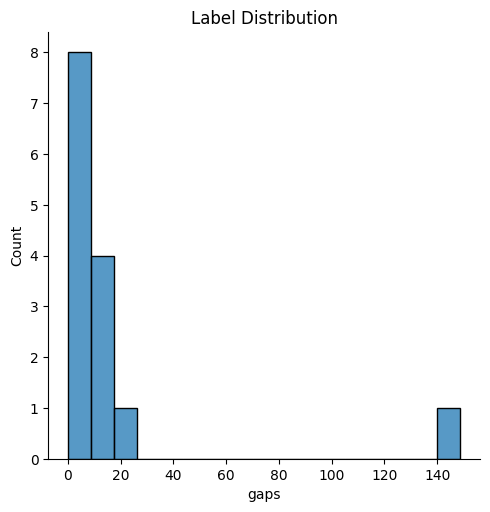

In [6]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["gaps"])
plt.title("Label Distribution")
plt.show()

/home/user/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

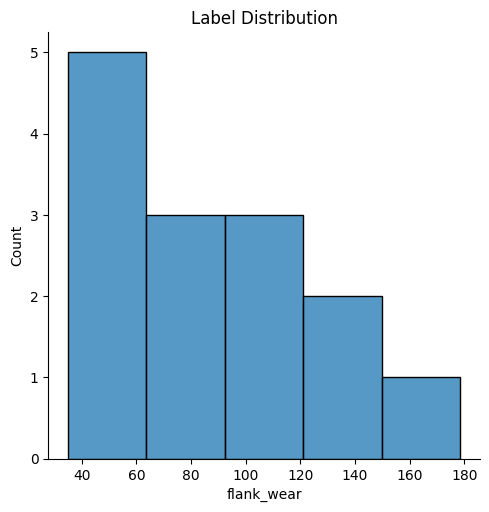

In [7]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["flank_wear"])
plt.title("Label Distribution")
plt.show()

/home/user/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

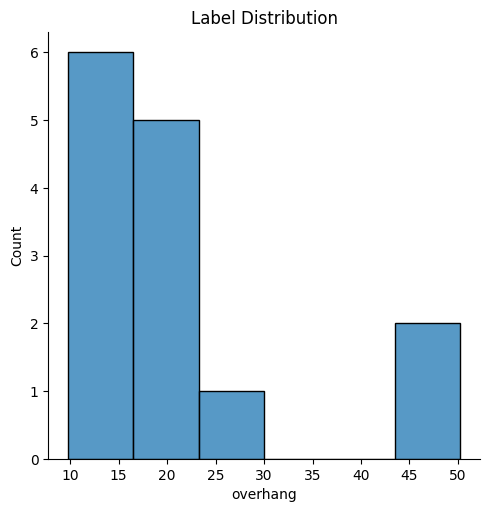

In [8]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["overhang"])
plt.title("Label Distribution")
plt.show()

In [9]:
print("check if permutation is same on all models")
print("train_head", train_df.head())
print("test_head", test_df.head())
print("val_head", val_df.head())

check if permutation is same on all models
train_head          id   gaps  flank_wear  overhang                            spec_x  \
14   T8R3B4   6.88       40.92     14.54   ../../dataset/spec/x/T8R3B4.jpg   
10   T6R9B3  12.94       95.63     16.65   ../../dataset/spec/x/T6R9B3.jpg   
0    T1R2B1   7.67       34.89     48.61   ../../dataset/spec/x/T1R2B1.jpg   
3   T2R13B4   0.00      122.59     25.55  ../../dataset/spec/x/T2R13B4.jpg   
1    T1R7B4  13.89       85.41     50.25   ../../dataset/spec/x/T1R7B4.jpg   

                              spec_y                            spec_z  \
14   ../../dataset/spec/y/T8R3B4.jpg   ../../dataset/spec/z/T8R3B4.jpg   
10   ../../dataset/spec/y/T6R9B3.jpg   ../../dataset/spec/z/T6R9B3.jpg   
0    ../../dataset/spec/y/T1R2B1.jpg   ../../dataset/spec/z/T1R2B1.jpg   
3   ../../dataset/spec/y/T2R13B4.jpg  ../../dataset/spec/z/T2R13B4.jpg   
1    ../../dataset/spec/y/T1R7B4.jpg   ../../dataset/spec/z/T1R7B4.jpg   

                              ch

In [10]:
def read_tools(file_paths, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []

    for file_path in file_paths:
        img = cv2.imread(file_path)
        res = cv2.resize(img, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        images.append(res)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / np.max(images)

    # reshape to match Keras expectaions
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)

    return images


def read_specs(file_paths_x, file_paths_y, file_paths_z, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []

    for i in range(file_paths_x.size):
        img_x = cv2.imread(file_paths_x[i])
        res_x = cv2.resize(
            img_x, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_x)
        img_y = cv2.imread(file_paths_y[i])
        res_y = cv2.resize(
            img_y, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_y)
        img_z = cv2.imread(file_paths_z[i])
        res_z = cv2.resize(
            img_z, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        images.append(res_z)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / np.max(images)

    # reshape to match Keras expectaions
    images = images.reshape(file_paths_x.shape[0], img_rows, img_cols, channels)

    return images

In [11]:
x_train_spec = read_specs(
    train_df.spec_x.values,
    train_df.spec_y.values,
    train_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)
x_test_spec = read_specs(
    test_df.spec_x.values,
    test_df.spec_y.values,
    test_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)
x_val_spec = read_specs(
    val_df.spec_x.values,
    val_df.spec_y.values,
    val_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)

x_train_chip = read_tools(train_df.chip.values, img_rows, img_cols, in_channel_chip)
x_test_chip = read_tools(test_df.chip.values, img_rows, img_cols, in_channel_chip)
x_val_chip = read_tools(val_df.chip.values, img_rows, img_cols, in_channel_chip)

In [12]:
x_train_spec.shape

(14, 256, 256, 9)

In [13]:
x_train_chip.shape

(14, 256, 256, 3)

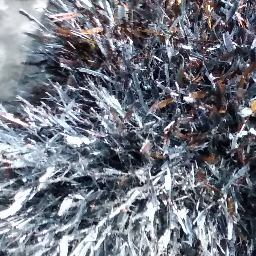

In [14]:
pil_img = tf.keras.utils.array_to_img(x_train_chip[0])
pil_img

In [15]:
labels_train = train_df[["gaps", "flank_wear", "overhang"]]
labels_test = test_df[["gaps", "flank_wear", "overhang"]]
labels_val = val_df[["gaps", "flank_wear", "overhang"]]

In [16]:
# ============================== augment 1/2 ==============================
data_augmentation_spec = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_spec",
)

2023-09-23 13:52:42.922012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:52:42.923033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:52:42.923847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
# ============================== augment 2/2 ==============================
data_augmentation_chip = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_chip",
)

In [18]:
x_train_spec = data_augmentation_spec(x_train_spec)
x_train_chip = data_augmentation_chip(x_train_chip)

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_train_spec,
            "input_1_chip": x_train_chip,
        },
        labels_train,
    )
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_test_spec,
            "input_1_chip": x_test_chip,
        },
        labels_test,
    )
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_val_spec,
            "input_1_chip": x_val_chip,
        },
        labels_val,
    )
)

In [20]:
auto = tf.data.AUTOTUNE
inputs2 = k.Input(input_shape_spec)
inputs3 = k.Input(input_shape_chip)

In [21]:
def generate_datasets(images, is_train=False, shuffle=False):
    dataset = images
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        pass
    return dataset.prefetch(auto)

In [22]:
train_ds = generate_datasets(train_dataset, is_train=True, shuffle=True)
val_ds = generate_datasets(val_dataset)
test_ds = generate_datasets(test_dataset)

In [23]:
train_ds

<_PrefetchDataset element_spec=({'input_1_spec': TensorSpec(shape=(None, 256, 256, 9), dtype=tf.float32, name=None), 'input_1_chip': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [24]:
model_spec = k.models.load_model(model_spec_path, compile=False)
model_chip = k.models.load_model(model_chip_path, compile=False)

model_spec.trainable = False
model_chip.trainable = False


def load_multi_mixer(model_spec, model_chip):
    inputs2 = model_spec.input
    inputs2._name = "input_spec"
    inputs3 = model_chip.input
    inputs3._name = "input_chip"

    truncated_model_spec = k.Model(
        inputs=model_spec.input, outputs=model_spec.layers[-2].output
    )
    truncated_model_chip = k.Model(
        inputs=model_chip.input, outputs=model_chip.layers[-2].output
    )
    mergedOut = k.layers.Concatenate()(
        [
            truncated_model_spec.output,
            truncated_model_chip.output,
        ]
    )
    output = layers.Dense(num_classes, activation="linear", name="output_mult")(
        mergedOut
    )
    return k.Model(inputs=[inputs2, inputs3], outputs=output)


for layer in model_spec.layers:
    layer._name = layer.name + str("_spec")
for layer in model_chip.layers:
    layer._name = layer.name + str("_chip")

In [25]:
def launch_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer, loss="mse", metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
    )

    _, accuracy = model.evaluate(test_ds)
    print(f"Test error: {round(accuracy, 2)}")

    return history, model

In [26]:
model = load_multi_mixer(model_spec, model_chip)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_spec (InputLayer)      [(None, 256, 256, 9  0           []                               
                                )]                                                                
                                                                                                  
 input_1_chip (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_spec (Conv2D)           (None, 16, 16, 256)  590080      ['input_1_spec[0][0]']           
                                                                                            

In [27]:
history, model = launch_experiment(model)

Epoch 1/100


2023-09-23 13:52:48.160087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [14,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-09-23 13:52:48.160536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [14,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-09-23 13:52:57.242892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


2/2 [==============================] - ETA: 0s - loss: 3857.7585 - mean_squared_error: 3857.7585

2023-09-23 13:52:58.070840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,3]
	 [[{{node Placeholder/_2}}]]


2/2 [==============================] - 12s 2s/step - loss: 3857.7585 - mean_squared_error: 3857.7585 - val_loss: 4714.9077 - val_mean_squared_error: 4714.9077
Epoch 2/100
2/2 [==============================] - 0s 58ms/step - loss: 3750.6980 - mean_squared_error: 3750.6980 - val_loss: 4599.4800 - val_mean_squared_error: 4599.4800
Epoch 3/100
2/2 [==============================] - 0s 57ms/step - loss: 3668.4709 - mean_squared_error: 3668.4707 - val_loss: 4484.9888 - val_mean_squared_error: 4484.9888
Epoch 4/100
2/2 [==============================] - 0s 60ms/step - loss: 3576.6687 - mean_squared_error: 3576.6687 - val_loss: 4373.6890 - val_mean_squared_error: 4373.6890
Epoch 5/100
2/2 [==============================] - 0s 59ms/step - loss: 3490.8655 - mean_squared_error: 3490.8655 - val_loss: 4265.2905 - val_mean_squared_error: 4265.2905
Epoch 6/100
2/2 [==============================] - 0s 60ms/step - loss: 3404.4402 - mean_squared_error: 3404.4402 - val_loss: 4160.2310 - val_mean_square

2023-09-23 13:53:08.254792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,3]
	 [[{{node Placeholder/_2}}]]


In [28]:
model.save(model_save_path)

In [29]:
pred = model.predict(test_ds)

1/1 [==============================] - 2s 2s/step


In [30]:
# ============================== generate data ==============================
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import PredictionErrorDisplay
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as k

In [31]:
multi_pred = pred
gaps_pred, flank_wear_pred, overhang_pred = multi_pred.T

multi_true = labels_test.to_numpy()
gaps_true, flank_wear_true, overhang_true = multi_true.T

In [32]:
labels_list = [
    "gaps",
    "flank_wear",
    "overhang",
    "multi",
]
pred_list = [
    gaps_pred,
    flank_wear_pred,
    overhang_pred,
    multi_pred,
]
true_list = [
    gaps_true,
    flank_wear_true,
    overhang_true,
    multi_true,
]

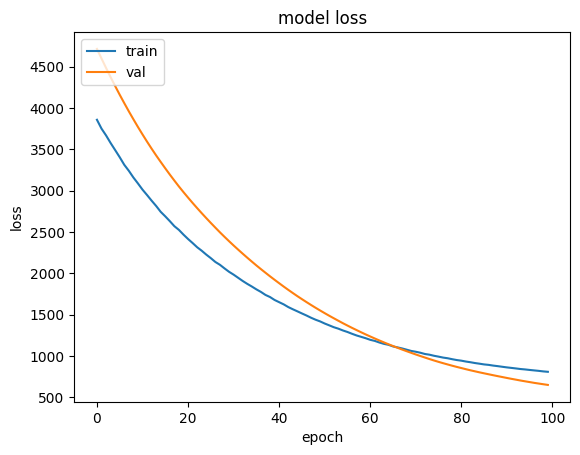

In [33]:
# loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

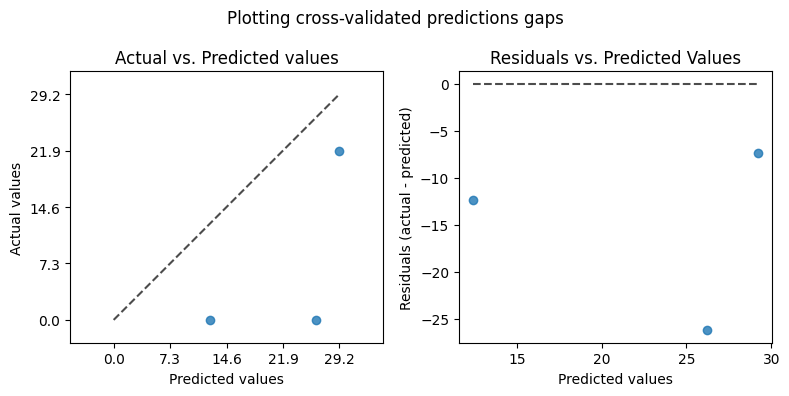

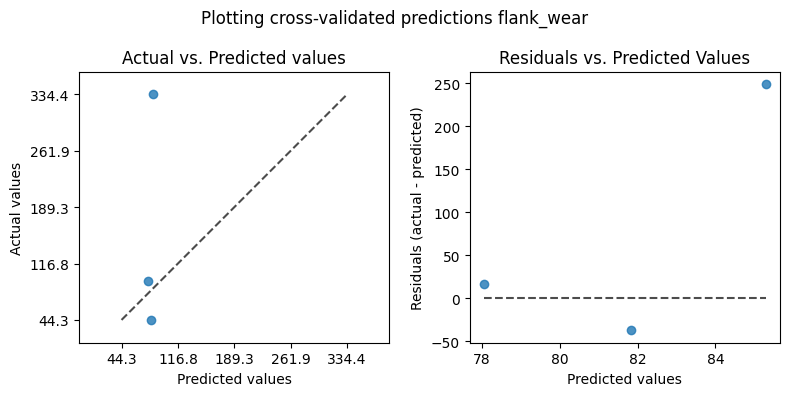

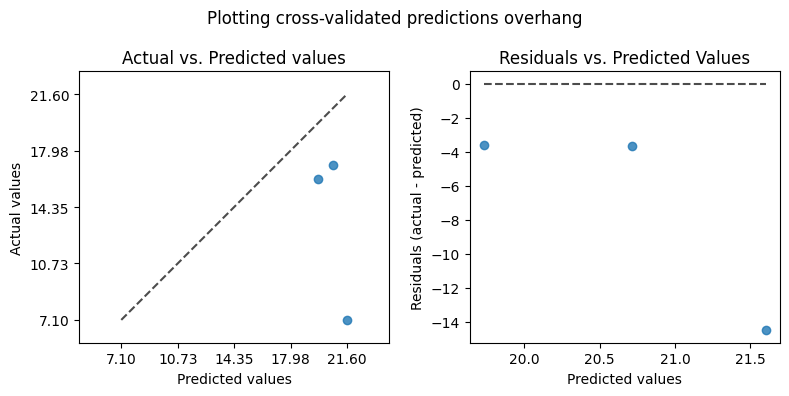

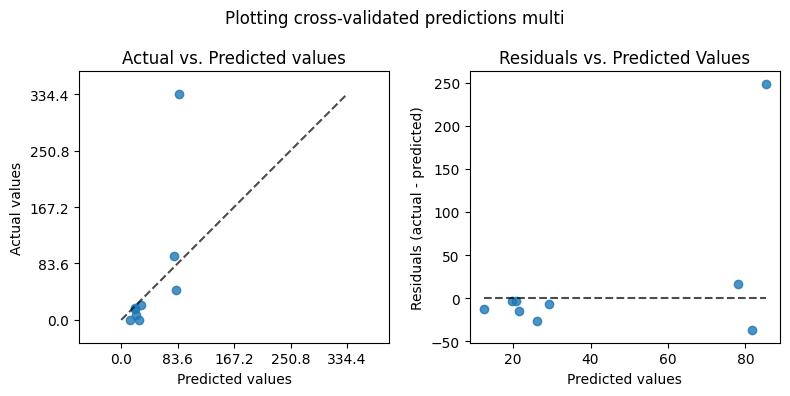

In [34]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions " + label)
    plt.tight_layout()
    plt.show()

In [35]:
def min_shift(list1, list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if list1.ndim == 2:
        for i in range(len(list1)):
            if np.min([list1, list2]) > 0:
                continue
            min = np.min([list1[i], list2[i]])
            list1[i] -= min
            list2[i] -= min
        return list1, list2

    min = np.min([list1, list2])
    list1 = list1 - min
    list2 = list1 - min

    return list1, list2

In [36]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    print(f"===== {label} results =====")
    print("MAE: ", metrics.mean_absolute_error(y_true, y_pred))
    print("MSE: ", metrics.mean_squared_error(y_true, y_pred))
    print("RMSE: ", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r2_score: ", metrics.r2_score(y_true, y_pred))
    try:
        print("MSLE: ", metrics.mean_squared_log_error(y_true, y_pred))
    except ValueError as err:
        y_true_shift, y_pred_shift = min_shift(y_true, y_pred)
        print(
            "MSLE_min_shifted: ",
            metrics.mean_squared_log_error(y_true_shift, y_pred_shift),
        )
    print("MAPE: ", metrics.mean_absolute_percentage_error(y_true, y_pred))

===== gaps results =====
MAE:  15.349377619425455
MSE:  298.9744523683195
RMSE:  17.290877721166137
r2_score:  -1.833558167794755
MSLE:  5.912927776846342
MAPE:  5.801326286506121e+16
===== flank_wear results =====
MAE:  101.07581837972005
MSE:  21244.43969031807
RMSE:  145.7547244185178
r2_score:  -0.3259248744699599
MSLE:  0.7480646112912525
MAPE:  0.5895718543473395
===== overhang results =====
MAE:  7.252483673095703
MSE:  78.89112043172123
RMSE:  8.88206735122636
r2_score:  -2.9108316169426263
MSLE:  0.3745069497921563
MAPE:  0.8267027991687007
===== multi results =====
MAE:  41.2258932240804
MSE:  7207.435087706038
RMSE:  57.30922316363677
r2_score:  -1.690104886402447
MSLE:  2.3451664459765835
MAPE:  1.9337754288353736e+16
